# 5.3 Visualization of AlphaMissense and ESM1b Scores

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path

# Change directory to the project root
os.chdir("/Users/doma/Documents/Bachelor_Arbeit/Code")
project_root = Path.cwd()
from src.plotting.plot_pathogenicity import plot_pathogenicity


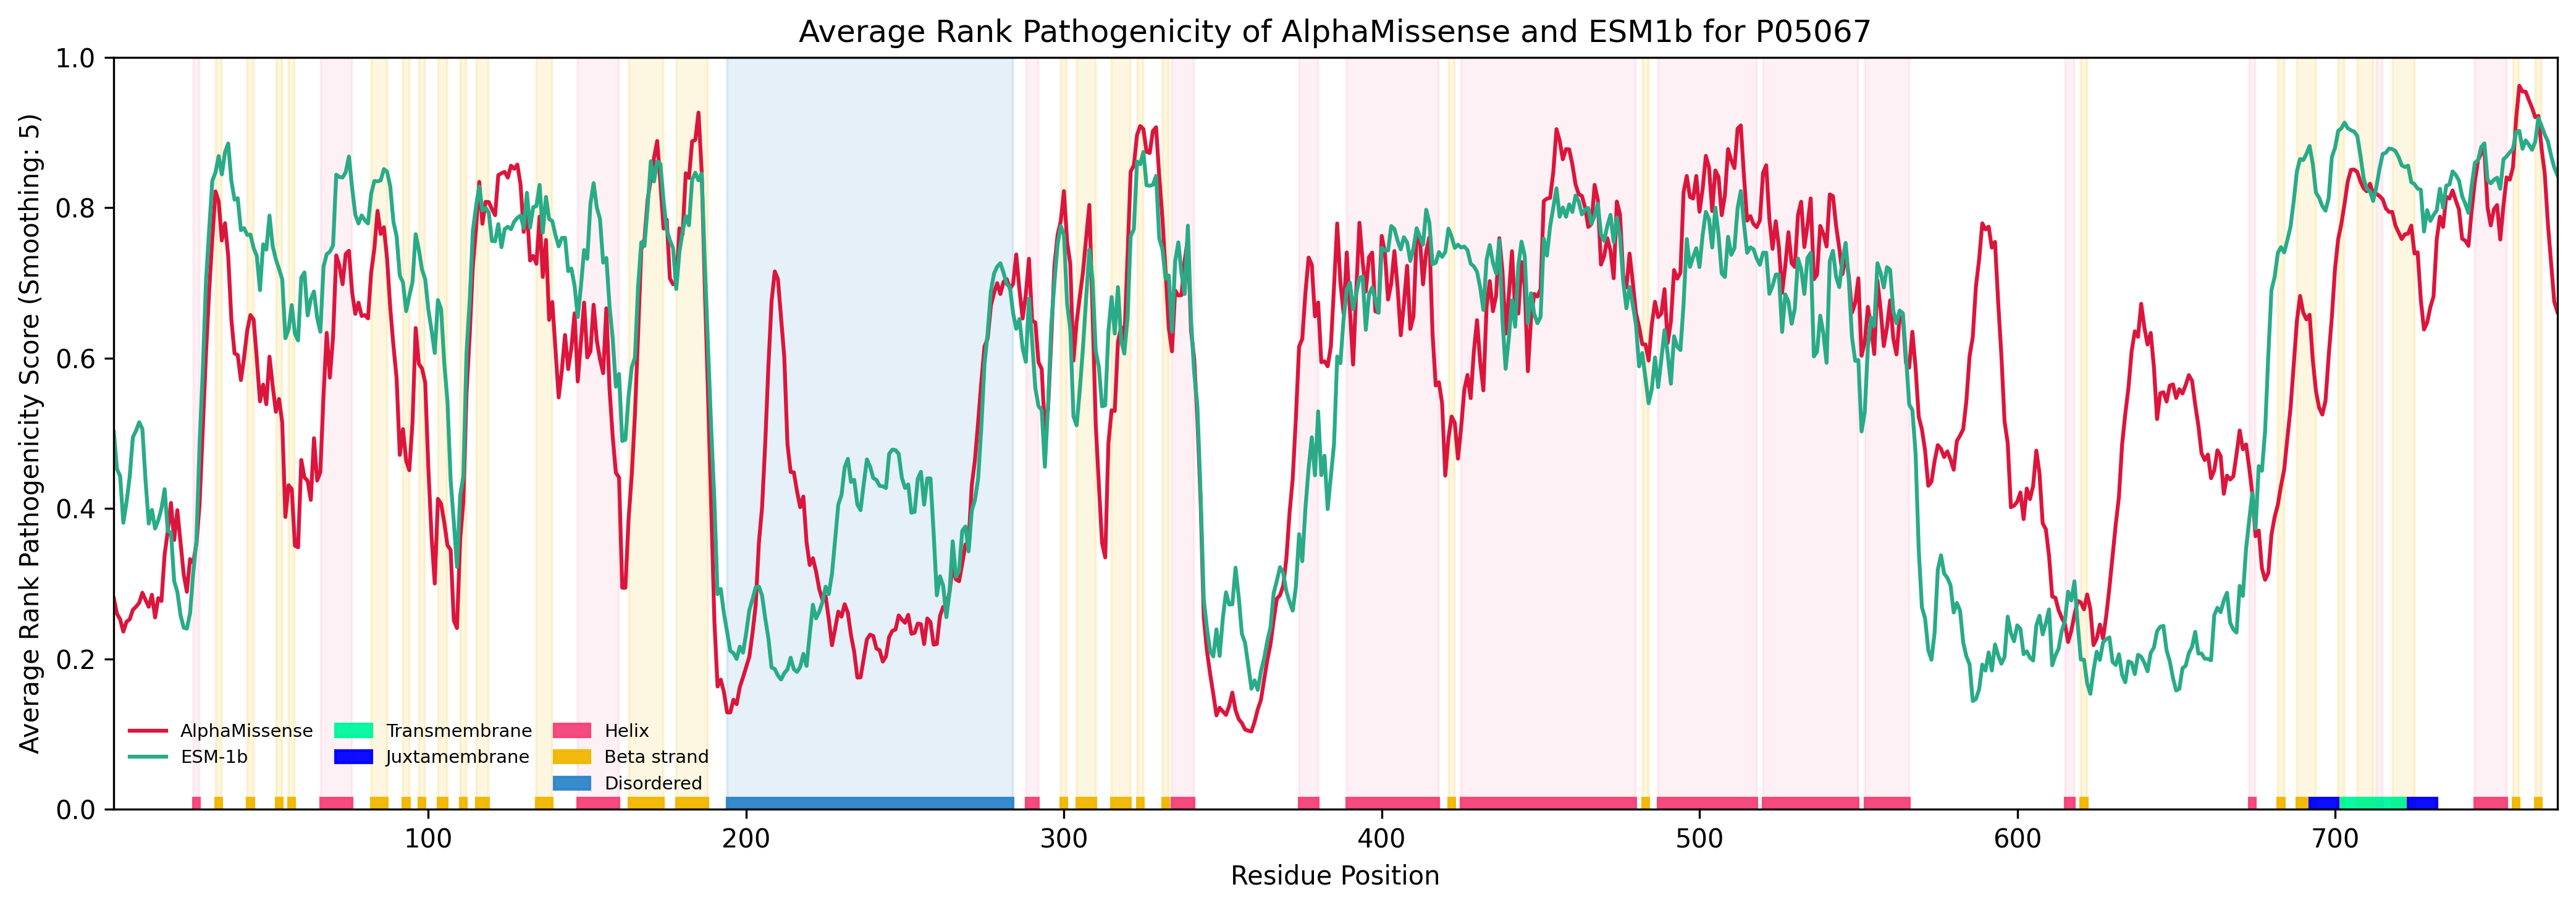

In [2]:
fig, ax = plot_pathogenicity(
    protein_id="P05067",
    curves="both",                          # "AlphaMissense", "ESM", or "both"
    rank=True,
    span="singlespan",
    method="mean",
    highlight=["Helix","Beta strand","Transmembrane", "Juxtamembrane", "Disordered"],
    smoothing_window=5,
    show_std=False,
    figsize=(14,5),
    save_path=True
)
plt.show()

# Plot of Pathogenicities Interactive

In [11]:
def plot_pathogenicity_interactive(
    protein_id,
    curves="both",
    data_dir="/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/Protein_Statistics",
    smoothing_window=5,
    title=None,
    show=True,
    save=None
):
    """
    Plot interactive pathogenicity visualization using Plotly.

    Parameters:
    - protein_id (str): Uniprot ID of the protein (e.g. "P05067")
    - curves (str): Which models to display: "AlphaMissense", "ESM", or "both"
    - data_dir (str): Optional path to CSV data directory. Uses relative path if None.
    - smoothing_window (int): Rolling mean window size.
    - title (str): Optional title override.
    - show (bool): If True, display the figure in browser.
    - save_path (str): If provided, saves HTML file to this path.
    """

    # Load data
    file_path = os.path.join(data_dir, f"{protein_id}_statistics.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"CSV not found: {file_path}")
    df = pd.read_csv(file_path)


    # Preprocessing
    df['Helix'] = df['Helix'].fillna(0).eq(1)
    df['Beta strand'] = df['Beta strand'].fillna(0).eq(1)
    df['Transmembrane_mask'] = df['Transmembrane'].astype(str).str.strip().str.lower().eq('helical')
    df['Juxtamembrane_mask'] = pd.to_numeric(df['Juxtamembrane'], errors='coerce').fillna(0).eq(1)
    df['Region_mask'] = df['Region'].astype(str).str.strip().str.lower().eq('disordered')

    # Smoothed curves
    df['AM_smoothed_pathogenicity'] = df['AM_mean'].rolling(window=smoothing_window, center=True, min_periods=1).mean()
    df['ESM_smoothed_pathogenicity'] = df['ESM_mean'].rolling(window=smoothing_window, center=True, min_periods=1).mean()

    all_curves = {
        "AlphaMissense": {
            'y_col': 'AM_smoothed_pathogenicity',
            'label': 'AlphaMissense',
            'color': 'crimson',
            'std_col': 'AM_std',
            'top10_col': 'AM_TMDJMD_top10',
            'top_variants': 'AM_top_var',
            'extra_hover_cols': ['residue', 'Region', 'Site', "Helix", "Beta strand", "Transmembrane", "Modified residue", "Glycosylation", "Juxtamembrane"]
        },
        "ESM": {
            'y_col': 'ESM_smoothed_pathogenicity',
            'label': 'ESM-1b',
            'color': '#29AB87',
            'std_col': 'ESM_std',
            'top10_col': 'ESM_TMDJMD_top10',
            'top_variants': 'ESM_top_var',
            'extra_hover_cols': ['residue', 'Region', 'Site', "Helix", "Beta strand", "Transmembrane", "Modified residue", "Glycosylation", "Juxtamembrane"]
        }
    }

    if curves == "both":
        curve_list = [all_curves["AlphaMissense"], all_curves["ESM"]]
    elif curves in all_curves:
        curve_list = [all_curves[curves]]
    else:
        raise ValueError("curves must be 'AlphaMissense', 'ESM', or 'both'")

    # Plot
    fig = go.Figure()
    for curve in curve_list:
        y_col = curve['y_col']
        std_col = curve.get('std_col')
        top10_col = curve.get('top10_col')
        top_var = curve.get('top_variants')
        label = curve.get('label', y_col)
        color = curve.get('color', 'gray')

        residue_col = 'residue'
        extra_cols = curve.get('extra_hover_cols', [])
        other_extras = [col for col in extra_cols if col != residue_col]

        custom_cols = [residue_col]
        if std_col: custom_cols.append(std_col)
        if top10_col: custom_cols.append(top10_col)
        if top_var: custom_cols.append(top_var)
        custom_cols += other_extras
        custom_cols = [col for col in custom_cols if col in df.columns]

        customdata = df[custom_cols].fillna(" ").replace("", " ").to_numpy()

        # Hovertemplate
        offset = 0
        hovertemplate = f"<b>{label}</b><br>Residue Pos: %{{x}}<br>Residue: %{{customdata[{offset}]}}"
        offset += 1

        if std_col in df.columns:
            hovertemplate += f"<br>Score: %{{y:.3f}}<br>Std Dev: %{{customdata[{offset}]:.3f}}"
            offset += 1
        else:
            hovertemplate += f"<br>Score: %{{y:.3f}}"

        if top10_col and top10_col in df.columns:
            hovertemplate += f"<br>Top TMD_JMD Mutations:<br>%{{customdata[{offset}]}}"
            offset += 1

        if top_var and top_var in df.columns:
            hovertemplate += f"<br>Top Variants:<br>%{{customdata[{offset}]}}"
            offset += 1

        for i, col in enumerate(other_extras):
            hovertemplate += f"<br>{col}: %{{customdata[{offset + i}]}}"

        hovertemplate += "<extra></extra>"

        fig.add_trace(go.Scatter(
            x=df['residue_position'],
            y=df[y_col],
            mode='lines',
            name=label,
            line=dict(color=color),
            customdata=customdata,
            hovertemplate=hovertemplate
        ))

        # Std shading
        if std_col and std_col in df.columns:
            def to_rgba(col, alpha=0.2):
                named = {
                    'gray': f'rgba(128,128,128,{alpha})',
                    'black': f'rgba(0,0,0,{alpha})',
                    'crimson': f'rgba(220,20,60,{alpha})',
                    '#29ab87': f'rgba(41,171,135,{alpha})'
                }
                col_lower = col.lower()
                if col_lower in named:
                    return named[col_lower]
                if col.startswith('#') and len(col) == 7:
                    try:
                        r = int(col[1:3], 16)
                        g = int(col[3:5], 16)
                        b = int(col[5:7], 16)
                        return f'rgba({r},{g},{b},{alpha})'
                    except:
                        return f'rgba(100,100,100,{alpha})'
                return f'rgba(100,100,100,{alpha})'

            fig.add_trace(go.Scatter(
                x=pd.concat([df['residue_position'], df['residue_position'][::-1]]),
                y=pd.concat([df[y_col] - df[std_col], (df[y_col] + df[std_col])[::-1]]),
                fill='toself',
                fillcolor=to_rgba(color, alpha=0.2),
                line=dict(color='rgba(0,0,0,0)'),
                hoverinfo='skip',
                showlegend=False
            ))

    fig.update_layout(
        title=title or f"Pathogenicity for {protein_id}",
        xaxis_title='Residue Position',
        yaxis_title='Pathogenicity Score',
        template='simple_white',
        height=500,
        width=1000,
        legend=dict(x=0.01, y=0.99, borderwidth=0, font=dict(size=10)),
        yaxis=dict(range=[0, 1.1])
        
    )

    if save:
        save_path_1 = os.path.join("/Users/doma/Documents/Bachelor_Arbeit/Code/results/images/5.3.Visualization", f"{protein_id}_{curves}_plotly.html")
        fig.write_html(save_path_1, include_plotlyjs='inline', full_html=True)

    if show:
        fig.show()

    return fig

In [12]:
fig = plot_pathogenicity_interactive(
    protein_id="P05067",
    curves="both",
    smoothing_window=8,
    save=True
)
